In [ ]:
import xgboost as xgb
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import plot_tree, DMatrix
import matplotlib.pyplot as plt
import graphviz
from xgboost import to_graphviz
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import DMatrix
import os
import xgboost
from graphviz import Source
import subprocess

In [12]:
df = pl.read_csv("all_final_data_2011.csv")
df

LSOA,Mean_Household_Income,Energy Efficiency,Fuel Poverty,No central heating,Gas,Electric,Oil,Solid fuel,Other including communal and renewable,Two or more types,1 bedroom,2 bedrooms,3 bedrooms,4 or more bedrooms,Owned outright,Owned with a mortgage or loan,Shared ownership,Rented from Local Authority,Other social rented,Private landlord or letting agency,Other private rented,Rent free,Year_built
str,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""E01000001""",74846,57.87683,4.2,10,82,572,10,0,189,13,416,250,155,43,355,178,3,33,8,247,17,35,1972
"""E01000002""",73325,65.359492,2.1,15,40,538,6,0,220,11,402,274,87,65,314,213,8,44,4,206,13,28,1972
"""E01000003""",44130,61.372987,5.5,23,498,209,1,0,69,17,501,232,46,3,184,143,1,239,56,166,11,17,1972
"""E01000005""",30781,66.293588,7.9,9,225,98,25,0,88,22,241,130,79,7,24,22,0,133,179,92,9,8,1982
"""E01032739""",68022,57.052271,16.7,54,250,335,3,0,25,9,353,256,34,24,104,88,1,5,6,358,29,85,1900
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""E01033601""",37445,68.637239,4.6,10,415,98,1,0,37,28,172,205,129,76,57,64,5,233,148,70,5,7,1982
"""E01033602""",33823,68.552885,4.5,34,455,49,1,1,69,36,251,200,151,39,48,44,9,263,148,121,5,7,1972
"""E01033603""",48140,65.132701,5.1,25,430,100,1,0,14,30,238,244,89,27,78,75,6,118,95,209,8,11,1900


**Load all the data in the heatings dataset into numpy arrays structure**

In [13]:
def load_data(file_path: str, feature_columns: list, target_column: str):
    """
    Load the dataset, normalize column names, and ensure all specified feature
    and target columns exist.
    """
    
    # Load data
    data = pl.read_csv(file_path)
    
    # Normalize DataFrame columns by stripping spaces and converting to lowercase
    normalized_columns = [col.strip().lower() for col in data.columns]
    data.columns = normalized_columns  # Update DataFrame columns
    
    # Normalize input feature and target column names
    normalized_feature_columns = [col.strip().lower() for col in feature_columns]
    normalized_target_column = target_column.strip().lower()
    
    # Debugging: Print normalized column names
    print(f"Normalized Dataset Columns: {data.columns}")
    
    # Verify feature and target columns
    missing_features = [col for col in normalized_feature_columns if col not in data.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in the dataset: {missing_features}")

    if normalized_target_column not in data.columns:
        raise ValueError(f"Missing target column in the dataset: {normalized_target_column}")

    # Select features and target based on normalized column names
    X = data.select(normalized_feature_columns)
    y = data.select(normalized_target_column)
    
    return X.to_numpy(), y.to_numpy().flatten()

**Loading the training data for the XGBoost Training**

In [14]:
def train_xgb_model_with_features(X_train, y_train, X_test, y_test, feature_columns):
    """
    Train an XGBoost model using the provided train/test data and compute performance metrics.

    Parameters:
        X_train (numpy.ndarray): Training features.
        y_train (numpy.ndarray): Training target values.
        X_test (numpy.ndarray): Testing features.
        y_test (numpy.ndarray): Testing target values.
        feature_columns (list): List of feature names.

    Returns:
        model: Trained XGBoost model.
        dict: Performance metrics.
    """

    try:
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_columns)
        dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_columns)
        
        # Define XGBoost parameters
        params = {
            "objective": "reg:squarederror",  # Use squared error for regression
            "eval_metric": "rmse",           # Root mean squared error as metric
            "max_depth": 6,                  # Limit tree depth
            "eta": 0.1,                      # Learning rate
            "verbosity": 1,                  # Verbosity of logging
        }

        # Train the model
        evals = [(dtrain, "train"), (dtest, "test")]
        model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10)

        # Predict on test data
        y_pred = model.predict(dtest)

        # Compute performance metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)

        performance_metrics = {
            "mse": mse,
            "rmse": rmse,
            "r2_score": r2
        }

        return model, performance_metrics
    except Exception as e:
        raise RuntimeError(f"Error while training model: {e}")

**Main Operation**

In [15]:
# Step 1: Load dataset
file_path = "all_final_data_2011.csv"  # Replace with your CSV file path
feature_columns = ['1 bedroom', '2 bedrooms', '3 bedrooms', '4 or more bedrooms'] 
target_column = "Energy Efficiency"

# Load dataset
X, y = load_data(file_path, feature_columns, target_column)

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model, metrics = train_xgb_model_with_features(X_train, y_train, X_test, y_test, feature_columns)

# Print results
print(f"Model Metrics: {metrics}")

Normalized Dataset Columns: ['lsoa', 'mean_household_income', 'energy efficiency', 'fuel poverty', 'no central heating', 'gas', 'electric', 'oil', 'solid fuel', 'other including communal and renewable', 'two or more types', '1 bedroom', '2 bedrooms', '3 bedrooms', '4 or more bedrooms', 'owned outright', 'owned with a mortgage or loan', 'shared ownership', 'rented from local authority', 'other social rented', 'private landlord or letting agency', 'other private rented', 'rent free', 'year_built']
[0]	train-rmse:4.67378	test-rmse:4.66455
[1]	train-rmse:4.50131	test-rmse:4.51796
[2]	train-rmse:4.35354	test-rmse:4.39197
[3]	train-rmse:4.22743	test-rmse:4.29391
[4]	train-rmse:4.11678	test-rmse:4.20439
[5]	train-rmse:4.01911	test-rmse:4.13632
[6]	train-rmse:3.93624	test-rmse:4.07268
[7]	train-rmse:3.86584	test-rmse:4.02924
[8]	train-rmse:3.80327	test-rmse:3.99311
[9]	train-rmse:3.74822	test-rmse:3.96185
[10]	train-rmse:3.69632	test-rmse:3.93260
[11]	train-rmse:3.65003	test-rmse:3.90879
[12]	

**Display the Results**

In [16]:
def plot_feature_importance(model, feature_names, normalize=False):
    """
    Visualize the feature importance of an XGBoost model, with optional normalization.

    Parameters:
    - model: Trained XGBoost model (can be XGBRegressor or XGBClassifier).
    - feature_names: List of feature names used during training.
    - normalize: Whether to normalize the feature importance scores so they sum to 100 (default: False).
    """


    # Retrieve feature importance scores (raw counts of splits for each feature)
    importance_dict = model.get_score(importance_type='weight')

    # Use the importance dictionary directly (keys are feature names)
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    # Extract feature names and their importance scores
    features, scores = zip(*sorted_importance)

    if normalize:
        # Normalize scores so they sum to 100
        total = sum(scores)
        scores = [(score / total) * 100 for score in scores]

    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores, color="steelblue")
    plt.gca().invert_yaxis()  # Reverse the order to have the most important on top
    plt.xlabel("Feature Importance (%)" if normalize else "Feature Importance (Weight)")
    plt.ylabel("Features")
    plt.title("Feature Importance")
    plt.show()

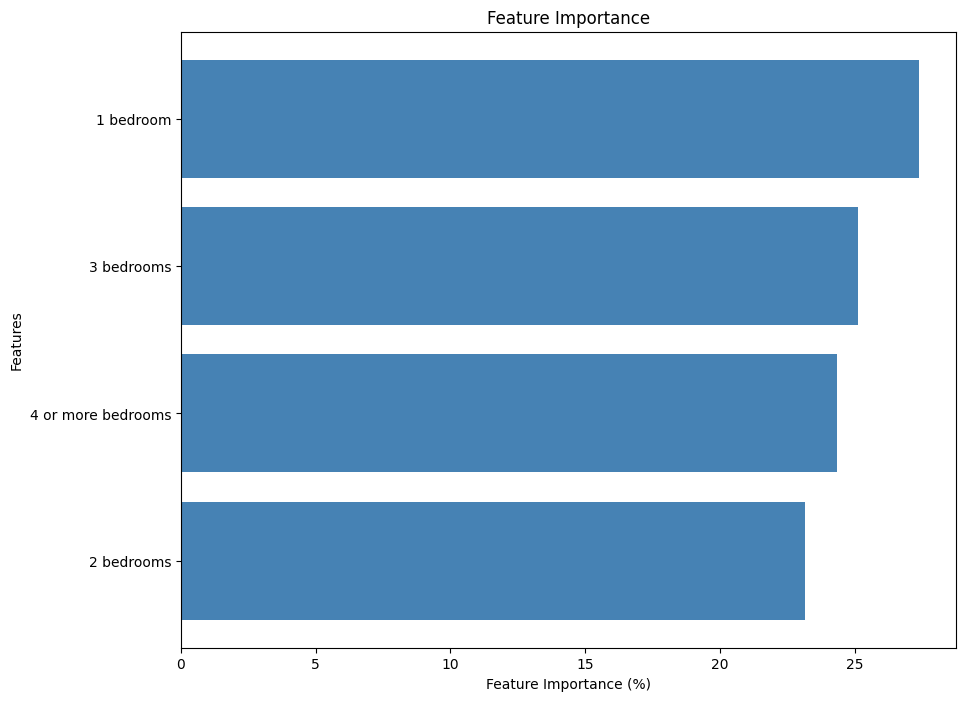

In [17]:
plot_feature_importance(model, feature_columns, normalize=True)